# Sales Decline Analysis – Erha Clinic

In [44]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score


In [45]:
# Data Dummy
np.random.seed(42)

n = 10000

data = pd.DataFrame({
    "ChannelCode": np.random.choice(["CH01","CH02","CH03","CH04"], n),
    "ChannelStoreName": np.random.choice(["Jakarta","Bandung","Surabaya","Medan"], n),
    "CustomerID": np.random.randint(1000,5000,n),
    "Gender": np.random.choice(["Male","Female"], n),
    "Age": np.random.randint(18,60,n),
    "City": np.random.choice(["Jakarta","Bandung","Surabaya","Medan"], n),
    "TglReg": pd.date_range(start="2023-01-01", periods=n, freq="H"),
    "ProductCode": np.random.choice(["PR01","PR02","PR03","PR04"], n),
    "ProductName": np.random.choice(["Acne Treatment","Facial","Skincare A","Skincare B"], n),
    "TotalSales": np.random.normal(500000,150000,n),
    "PaymentMethodType": np.random.choice(["Cash","Card","Transfer"], n),
    "DoctorID": np.random.choice(["D01","D02","D03","D04","D05"], n),
    "MedicalJobdesk": np.random.choice(["Doctor","Nurse"], n)
})

data.head()


/tmp/ipython-input-3290107167.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "TglReg": pd.date_range(start="2023-01-01", periods=n, freq="H"),


,ChannelCode,ChannelStoreName,CustomerID,Gender,Age,City,TglReg,ProductCode,ProductName,TotalSales,PaymentMethodType,DoctorID,MedicalJobdesk
0,CH03,Surabaya,4254,Male,54,Surabaya,2023-01-01 00:00:00,PR04,Facial,376496.921921,Card,D01,Doctor
1,CH04,Medan,1863,Female,46,Bandung,2023-01-01 01:00:00,PR03,Acne Treatment,586325.717319,Cash,D04,Nurse
2,CH01,Surabaya,3595,Female,32,Surabaya,2023-01-01 02:00:00,PR02,Acne Treatment,455866.787888,Card,D05,Doctor
3,CH03,Medan,4953,Female,44,Surabaya,2023-01-01 03:00:00,PR03,Skincare A,617242.277226,Card,D04,Doctor
4,CH03,Medan,4108,Male,25,Surabaya,2023-01-01 04:00:00,PR03,Acne Treatment,320356.373139,Cash,D01,Doctor


In [46]:
# Data Cleaning, Feature Engineering
data['TglReg'] = pd.to_datetime(data['TglReg'])
data['Year'] = data['TglReg'].dt.year
data['Month'] = data['TglReg'].dt.month

# Remove negative sales
data = data[data['TotalSales'] > 0]

# Customer Type
data['CustomerType'] = np.where(
    data.groupby('CustomerID')['TglReg'].rank(method='first') == 1,
    'New',
    'Existing'
)


In [47]:
data.head()

,ChannelCode,ChannelStoreName,CustomerID,Gender,Age,City,TglReg,ProductCode,ProductName,TotalSales,PaymentMethodType,DoctorID,MedicalJobdesk,Year,Month,CustomerType
0,CH03,Surabaya,4254,Male,54,Surabaya,2023-01-01 00:00:00,PR04,Facial,376496.921921,Card,D01,Doctor,2023,1,New
1,CH04,Medan,1863,Female,46,Bandung,2023-01-01 01:00:00,PR03,Acne Treatment,586325.717319,Cash,D04,Nurse,2023,1,New
2,CH01,Surabaya,3595,Female,32,Surabaya,2023-01-01 02:00:00,PR02,Acne Treatment,455866.787888,Card,D05,Doctor,2023,1,New
3,CH03,Medan,4953,Female,44,Surabaya,2023-01-01 03:00:00,PR03,Skincare A,617242.277226,Card,D04,Doctor,2023,1,New
4,CH03,Medan,4108,Male,25,Surabaya,2023-01-01 04:00:00,PR03,Acne Treatment,320356.373139,Cash,D01,Doctor,2023,1,New


### EDA

In [48]:
data.describe()


,CustomerID,Age,TglReg,TotalSales,Year,Month
count,9998.000000,9998.000000,9998,9.998000e+03,9998.000000,9998.000000
mean,2997.103321,38.707842,2023-07-28 07:26:22.876575232,5.020585e+05,2023.124025,5.889978
min,1000.000000,18.000000,2023-01-01 00:00:00,3.655812e+03,2023.000000,1.000000
25%,2016.000000,28.000000,2023-04-15 03:15:00,4.012247e+05,2023.000000,2.000000
50%,2973.500000,39.000000,2023-07-28 07:30:00,5.019029e+05,2023.000000,6.000000
75%,3987.750000,49.000000,2023-11-09 11:45:00,6.022662e+05,2023.000000,9.000000
max,4999.000000,59.000000,2024-02-21 15:00:00,1.114918e+06,2024.000000,12.000000
std,1147.632778,12.086033,NaN,1.512397e+05,0.329626,3.646983


In [49]:
# Total sales per bulan
data['YearMonth'] = data['TglReg'].dt.to_period('M')
monthly_revenue = data.groupby('YearMonth')['TotalSales'].sum().reset_index()
avg_monthly_revenue = monthly_revenue['TotalSales'].mean()

print("Rata-rata pendapatan per bulan:", round(avg_monthly_revenue, 2))

Rata-rata pendapatan per bulan: 358541479.12


In [50]:
# Jumlah customer by umur
age_visit = data.groupby('Age')['CustomerID'].count().reset_index()
age_visit = age_visit.sort_values(by='CustomerID', ascending=False)

print(age_visit.head())

    Age  CustomerID
12   30         271
22   40         267
36   54         266
28   46         261
40   58         260


In [51]:
# Kategori umur
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels)

age_group_summary = data.groupby('AgeGroup')['CustomerID'].count().reset_index()
age_group_summary = age_group_summary.sort_values(by='CustomerID', ascending=False)

print(age_group_summary)

  AgeGroup  CustomerID
3    40-49        2420
2    30-39        2390
1    20-29        2351
4    50-59        2160
0      <20         677
5      60+           0


/tmp/ipython-input-1146347874.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_summary = data.groupby('AgeGroup')['CustomerID'].count().reset_index()


In [52]:
# Top produk
product_summary = data.groupby('ProductName')['CustomerID'].count().reset_index()
product_summary = product_summary.sort_values(by='CustomerID', ascending=False)

print(product_summary.head())

      ProductName  CustomerID
0  Acne Treatment        2567
2      Skincare A        2508
3      Skincare B        2463
1          Facial        2460


In [53]:
# Top produk by total sales
product_revenue = data.groupby('ProductName')['TotalSales'].sum().reset_index()
product_revenue = product_revenue.sort_values(by='TotalSales', ascending=False)

print(product_revenue.head())

      ProductName    TotalSales
0  Acne Treatment  1.283637e+09
2      Skincare A  1.264120e+09
1          Facial  1.237849e+09
3      Skincare B  1.233976e+09


In [54]:
# Top dokter
doctor_visit = data.groupby('DoctorID')['CustomerID'].count().reset_index()
doctor_visit = doctor_visit.sort_values(by='CustomerID', ascending=False)

doctor_summary = data.groupby('DoctorID').agg({
    'CustomerID': 'count',
    'TotalSales': 'sum'
}).reset_index()

doctor_summary = doctor_summary.sort_values(by='CustomerID', ascending=False)

print(doctor_summary.head())

  DoctorID  CustomerID    TotalSales
4      D05        2034  1.019996e+09
1      D02        2021  1.007991e+09
0      D01        1996  1.004533e+09
2      D03        1995  1.011965e+09
3      D04        1952  9.750968e+08


In [55]:
# Top store
store_revenue = data.groupby('ChannelStoreName')['TotalSales'].sum().reset_index()
store_revenue = store_revenue.sort_values(by='TotalSales', ascending=False)

store_summary = data.groupby('ChannelStoreName').agg({
    'CustomerID': 'count',
    'TotalSales': 'sum'
}).reset_index()

store_summary = store_summary.sort_values(by='TotalSales', ascending=False)

print(store_summary)

  ChannelStoreName  CustomerID    TotalSales
1          Jakarta        2560  1.273964e+09
0          Bandung        2501  1.258626e+09
2            Medan        2492  1.255058e+09
3         Surabaya        2445  1.231934e+09


In [56]:
# data_2023 = data[data['Year'] == 2023].copy()
# data_2024 = data[data['Year'] == 2024].copy()

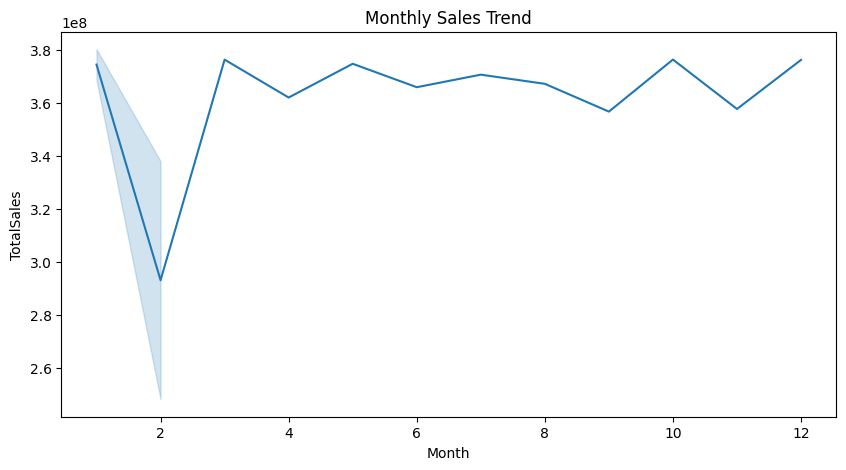

In [57]:
# EDA
monthly_sales = data.groupby(['Year','Month'])['TotalSales'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='Month', y='TotalSales')
plt.title("Monthly Sales Trend")
plt.show()


In [58]:
display(monthly_sales)

,Year,Month,TotalSales
0,2023,1,3.687135e+08
1,2023,2,3.380257e+08
2,2023,3,3.763768e+08
3,2023,4,3.620689e+08
4,2023,5,3.748117e+08
5,2023,6,3.659668e+08
6,2023,7,3.707017e+08
7,2023,8,3.672470e+08
8,2023,9,3.567559e+08
9,2023,10,3.764046e+08


In [59]:
traffic_breakdown = data.groupby(['Year','Month','CustomerType'])['CustomerID'].nunique().unstack()
traffic_breakdown


CustomerType  Existing  New
Year Month                 
2023 1              57  684
     2             151  508
     3             234  491
     4             330  356
     5             382  333
     6             406  284
     7             464  236
     8             500  205
     9             510  157
     10            559  133
     11            571  100
     12            589   91
2024 1             599   85
     2             424   47

### Decomposition Analyst

In [60]:
# Decomposition Analysis
monthly_metrics = data.groupby(['Year','Month']).agg(
    Traffic=('CustomerID','nunique'),
    TotalSales=('TotalSales','sum')
).reset_index()

monthly_metrics['BasketSize'] = (
    monthly_metrics['TotalSales'] / monthly_metrics['Traffic']
)

monthly_metrics['Traffic_MoM'] = monthly_metrics['Traffic'].pct_change()
monthly_metrics['Basket_MoM'] = monthly_metrics['BasketSize'].pct_change()
monthly_metrics['Sales_MoM'] = monthly_metrics['TotalSales'].pct_change()

monthly_metrics


,Year,Month,Traffic,TotalSales,BasketSize,Traffic_MoM,Basket_MoM,Sales_MoM
0,2023,1,684,3.687135e+08,539054.893887,NaN,NaN,NaN
1,2023,2,618,3.380257e+08,546967.109631,-0.096491,0.014678,-0.083230
2,2023,3,680,3.763768e+08,553495.283267,0.100324,0.011935,0.113456
3,2023,4,658,3.620689e+08,550256.702109,-0.032353,-0.005851,-0.038015
4,2023,5,676,3.748117e+08,554455.104331,0.027356,0.007630,0.035194
5,2023,6,662,3.659668e+08,552819.939227,-0.020710,-0.002949,-0.023598
6,2023,7,679,3.707017e+08,545952.399801,0.025680,-0.012423,0.012938
7,2023,8,683,3.672470e+08,537696.870166,0.005891,-0.015121,-0.009319
8,2023,9,654,3.567559e+08,545498.273778,-0.042460,0.014509,-0.028567
9,2023,10,685,3.764046e+08,549495.710404,0.047401,0.007328,0.055076


### Store Analysis

In [61]:
# Filter hanya Februari 2023 dan 2024
feb_data = data[
    ((data['Year'] == 2023) & (data['Month'] == 2)) |
    ((data['Year'] == 2024) & (data['Month'] == 2))
].copy()


In [62]:
store_feb = feb_data.groupby(
    ['Year', 'ChannelStoreName']
)['TotalSales'].sum().reset_index()

store_feb_pivot = store_feb.pivot(
    index='ChannelStoreName',
    columns='Year',
    values='TotalSales'
)

store_feb_pivot = store_feb_pivot.rename(columns={
    2023: 'Feb_2023',
    2024: 'Feb_2024'
})

# Hitung selisih dan growth
store_feb_pivot['Diff'] = (
    store_feb_pivot['Feb_2024'] - store_feb_pivot['Feb_2023']
)

store_feb_pivot['YoY_%'] = (
    store_feb_pivot['Diff'] / store_feb_pivot['Feb_2023']
)

store_feb_pivot = store_feb_pivot.sort_values('Diff')

store_feb_pivot


Year,Feb_2023,Feb_2024,Diff,YoY_%
ChannelStoreName,,,,
Surabaya,8.692068e+07,5.358878e+07,-3.333189e+07,-0.383475
Bandung,9.130871e+07,6.185289e+07,-2.945582e+07,-0.322596
Jakarta,8.271777e+07,6.265254e+07,-2.006524e+07,-0.242575
Medan,7.707852e+07,7.007753e+07,-7.000983e+06,-0.090829


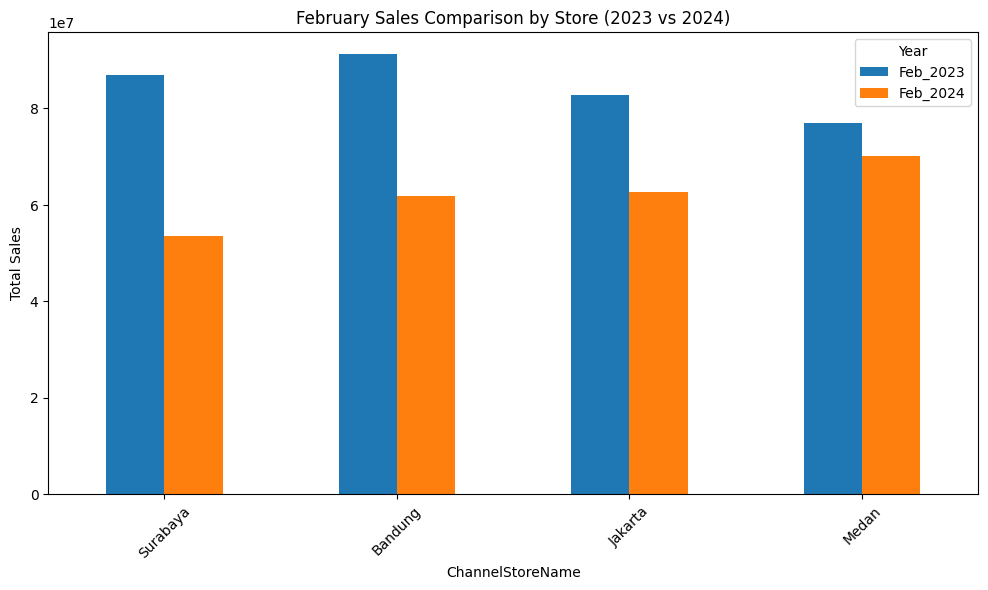

In [63]:
store_feb_pivot[['Feb_2023','Feb_2024']].plot(
    kind='bar',
    figsize=(12,6)
)

plt.title("February Sales Comparison by Store (2023 vs 2024)")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [64]:
total_drop = store_feb_pivot['Diff'].sum()

store_feb_pivot['Contribution_%'] = (
    store_feb_pivot['Diff'] / total_drop
)

store_feb_pivot


Year,Feb_2023,Feb_2024,Diff,YoY_%,Contribution_%
ChannelStoreName,,,,,
Surabaya,8.692068e+07,5.358878e+07,-3.333189e+07,-0.383475,0.370956
Bandung,9.130871e+07,6.185289e+07,-2.945582e+07,-0.322596,0.327819
Jakarta,8.271777e+07,6.265254e+07,-2.006524e+07,-0.242575,0.223310
Medan,7.707852e+07,7.007753e+07,-7.000983e+06,-0.090829,0.077915


### Doctor Performance

In [65]:
# Filter khusus Februari 2023 & 2024
feb_data = data[
    ((data['Year'] == 2023) & (data['Month'] == 2)) |
    ((data['Year'] == 2024) & (data['Month'] == 2))
].copy()


In [66]:
doctor_feb = feb_data.groupby(
    ['Year', 'DoctorID']
)['TotalSales'].sum().reset_index()

doctor_feb_pivot = doctor_feb.pivot(
    index='DoctorID',
    columns='Year',
    values='TotalSales'
)

doctor_feb_pivot = doctor_feb_pivot.rename(columns={
    2023: 'Feb_2023',
    2024: 'Feb_2024'
})

# Hitung selisih & YoY growth
doctor_feb_pivot['Diff'] = (
    doctor_feb_pivot['Feb_2024'] - doctor_feb_pivot['Feb_2023']
)

doctor_feb_pivot['YoY_%'] = (
    doctor_feb_pivot['Diff'] / doctor_feb_pivot['Feb_2023']
)

doctor_feb_pivot = doctor_feb_pivot.sort_values('Diff')

doctor_feb_pivot


Year,Feb_2023,Feb_2024,Diff,YoY_%
DoctorID,,,,
D05,7.522606e+07,4.796640e+07,-2.725967e+07,-0.362370
D04,6.705055e+07,4.828288e+07,-1.876767e+07,-0.279903
D02,6.938371e+07,5.197723e+07,-1.740648e+07,-0.250873
D03,6.594710e+07,5.070221e+07,-1.524489e+07,-0.231168
D01,6.041825e+07,4.924302e+07,-1.117523e+07,-0.184964


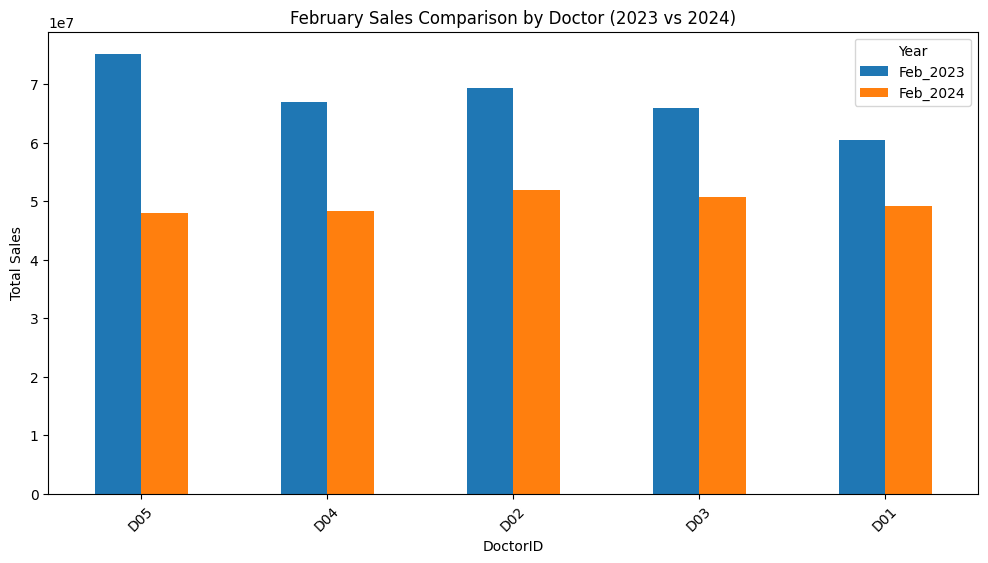

In [67]:
doctor_feb_pivot[['Feb_2023','Feb_2024']].plot(
    kind='bar',
    figsize=(12,6)
)

plt.title("February Sales Comparison by Doctor (2023 vs 2024)")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [68]:
total_drop = doctor_feb_pivot['Diff'].sum()

doctor_feb_pivot['Contribution_%'] = (
    doctor_feb_pivot['Diff'] / total_drop
)

doctor_feb_pivot


Year,Feb_2023,Feb_2024,Diff,YoY_%,Contribution_%
DoctorID,,,,,
D05,7.522606e+07,4.796640e+07,-2.725967e+07,-0.362370,0.303378
D04,6.705055e+07,4.828288e+07,-1.876767e+07,-0.279903,0.208869
D02,6.938371e+07,5.197723e+07,-1.740648e+07,-0.250873,0.193720
D03,6.594710e+07,5.070221e+07,-1.524489e+07,-0.231168,0.169663
D01,6.041825e+07,4.924302e+07,-1.117523e+07,-0.184964,0.124371


### Product Analysis

In [69]:
feb_data = data[
    ((data['Year'] == 2023) & (data['Month'] == 2)) |
    ((data['Year'] == 2024) & (data['Month'] == 2))
].copy()


In [70]:
product_feb = feb_data.groupby(
    ['Year', 'ProductName']
)['TotalSales'].sum().reset_index()

product_feb_pivot = product_feb.pivot(
    index='ProductName',
    columns='Year',
    values='TotalSales'
)

product_feb_pivot = product_feb_pivot.rename(columns={
    2023: 'Feb_2023',
    2024: 'Feb_2024'
})

# Hitung selisih dan growth
product_feb_pivot['Diff'] = (
    product_feb_pivot['Feb_2024'] - product_feb_pivot['Feb_2023']
)

product_feb_pivot['YoY_%'] = (
    product_feb_pivot['Diff'] / product_feb_pivot['Feb_2023']
)

product_feb_pivot = product_feb_pivot.sort_values('Diff')

product_feb_pivot


Year,Feb_2023,Feb_2024,Diff,YoY_%
ProductName,,,,
Acne Treatment,9.121018e+07,6.340894e+07,-2.780123e+07,-0.304804
Facial,8.740950e+07,5.972310e+07,-2.768640e+07,-0.316744
Skincare A,8.028609e+07,6.297173e+07,-1.731436e+07,-0.215658
Skincare B,7.911991e+07,6.206796e+07,-1.705194e+07,-0.215520


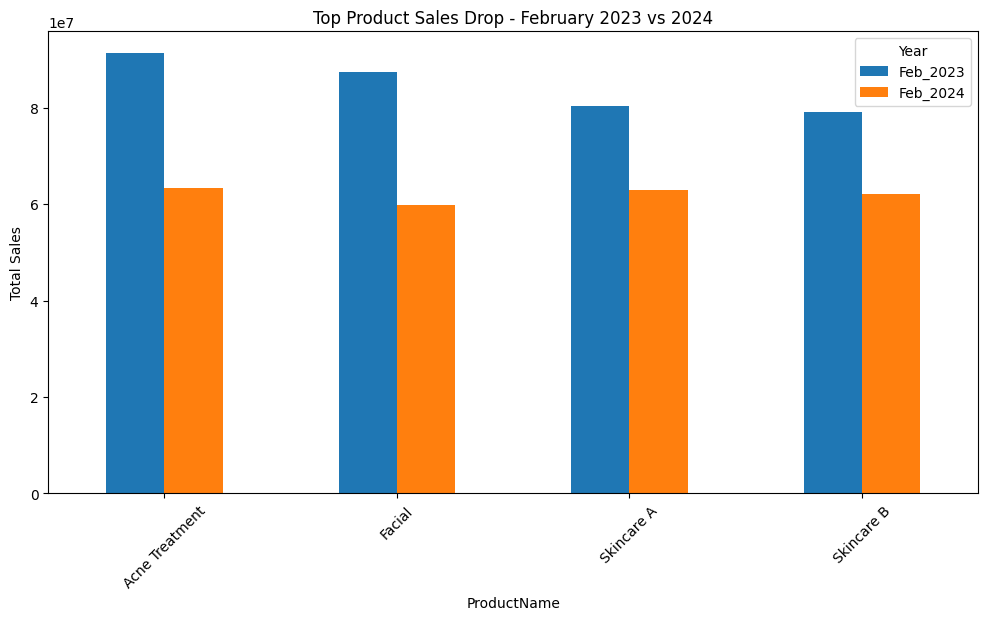

In [71]:
top_drop_products = product_feb_pivot.sort_values(
    'Diff'
).head(10)

top_drop_products[['Feb_2023','Feb_2024']].plot(
    kind='bar',
    figsize=(12,6)
)

plt.title("Top Product Sales Drop - February 2023 vs 2024")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [72]:
total_drop = product_feb_pivot['Diff'].sum()

product_feb_pivot['Contribution_%'] = (
    product_feb_pivot['Diff'] / total_drop
)

product_feb_pivot.sort_values('Contribution_%')


Year,Feb_2023,Feb_2024,Diff,YoY_%,Contribution_%
ProductName,,,,,
Skincare B,7.911991e+07,6.206796e+07,-1.705194e+07,-0.215520,0.189774
Skincare A,8.028609e+07,6.297173e+07,-1.731436e+07,-0.215658,0.192695
Facial,8.740950e+07,5.972310e+07,-2.768640e+07,-0.316744,0.308127
Acne Treatment,9.121018e+07,6.340894e+07,-2.780123e+07,-0.304804,0.309405


### Customer Behavior (Churn vs Retention)

In [73]:
# Filter Jan & Feb 2024
jan_feb_2024 = data[
    (data['Year'] == 2024) &
    (data['Month'].isin([1,2]))
].copy()

# Customer per bulan
jan_customers = set(
    jan_feb_2024[jan_feb_2024['Month'] == 1]['CustomerID'].unique()
)

feb_customers = set(
    jan_feb_2024[jan_feb_2024['Month'] == 2]['CustomerID'].unique()
)


In [74]:
retained = jan_customers & feb_customers
churned = jan_customers - feb_customers
new_feb = feb_customers - jan_customers

print("Total Jan 2024:", len(jan_customers))
print("Total Feb 2024:", len(feb_customers))
print("Retained:", len(retained))
print("Churned:", len(churned))
print("New in Feb:", len(new_feb))

retention_rate = len(retained) / len(jan_customers)
churn_rate = len(churned) / len(jan_customers)

print("Retention Rate:", round(retention_rate*100,2), "%")
print("Churn Rate:", round(churn_rate*100,2), "%")


Total Jan 2024: 679
Total Feb 2024: 467
Retained: 77
Churned: 602
New in Feb: 390
Retention Rate: 11.34 %
Churn Rate: 88.66 %


### Revenue per Existing vs New Customer (Feb 2024)

In [75]:
# Ambil data Februari 2024
feb_2024 = data[
    (data['Year'] == 2024) &
    (data['Month'] == 2)
].copy()

# Label customer type berdasarkan Jan
feb_2024['CustomerStatus'] = feb_2024['CustomerID'].apply(
    lambda x: 'Retained' if x in retained else 'New'
)


In [76]:
revenue_analysis = feb_2024.groupby('CustomerStatus').agg(
    TotalRevenue=('TotalSales','sum'),
    CustomerCount=('CustomerID','nunique')
).reset_index()

revenue_analysis['AvgRevenuePerCustomer'] = (
    revenue_analysis['TotalRevenue'] /
    revenue_analysis['CustomerCount']
)

revenue_analysis


,CustomerStatus,TotalRevenue,CustomerCount,AvgRevenuePerCustomer
0,New,2.094546e+08,390,537063.123048
1,Retained,3.871712e+07,77,502819.750477


### Compare 2023

In [77]:
# Filter Jan & Feb 2023
jan_feb_2023 = data[
    (data['Year'] == 2023) &
    (data['Month'].isin([1,2]))
].copy()

jan_2023 = set(
    jan_feb_2023[jan_feb_2023['Month'] == 1]['CustomerID'].unique()
)

feb_2023 = set(
    jan_feb_2023[jan_feb_2023['Month'] == 2]['CustomerID'].unique()
)


In [78]:
retained_2023 = jan_2023 & feb_2023
churned_2023 = jan_2023 - feb_2023
new_feb_2023 = feb_2023 - jan_2023

print("=== 2023 ===")
print("Total Jan 2023:", len(jan_2023))
print("Total Feb 2023:", len(feb_2023))
print("Retained:", len(retained_2023))
print("Churned:", len(churned_2023))
print("New in Feb:", len(new_feb_2023))

retention_2023 = len(retained_2023) / len(jan_2023)
churn_2023 = len(churned_2023) / len(jan_2023)

print("Retention Rate 2023:", round(retention_2023*100,2), "%")
print("Churn Rate 2023:", round(churn_2023*100,2), "%")


=== 2023 ===
Total Jan 2023: 684
Total Feb 2023: 618
Retained: 110
Churned: 574
New in Feb: 508
Retention Rate 2023: 16.08 %
Churn Rate 2023: 83.92 %


In [79]:
comparison = pd.DataFrame({
    'Year': [2023, 2024],
    'Retention_Rate': [retention_2023, 0.1134],
    'Churn_Rate': [churn_2023, 0.8866]
})

comparison


,Year,Retention_Rate,Churn_Rate
0,2023,0.160819,0.839181
1,2024,0.113400,0.886600
